In [3]:
!pip install tensorflow keras numpy matplotlib pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pandas-2.3.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.

In [4]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [kaggle]2m5/6 [kaggle]

[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/a1234/.kaggle: File exists


In [5]:
!unzip archive

Archive:  archive.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_xray/__MACOSX/

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

In [22]:
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode='binary'  # Binary: 0=normal, 1=pneumonia
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


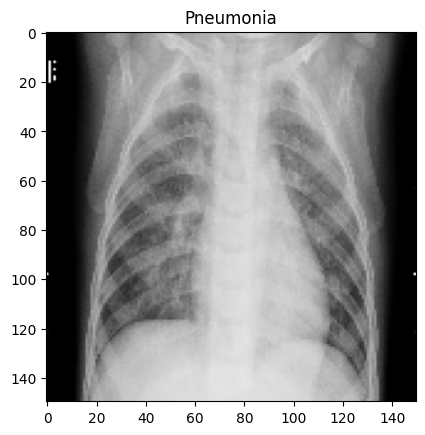

In [25]:
# Get a batch of images
images, labels = next(train_generator)
plt.imshow(images[0])
plt.title('Normal' if labels[0] == 0 else 'Pneumonia')
plt.show()

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained model (without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers to use pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/var/folders/yp/q9ntht1j0s17pqm37ww6nwy00000gn/T/ipykernel_4614/2096215728.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Adjust based on your data size
    epochs=5,  # Start small to test
    validation_data=val_generator,
    validation_steps=5
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.8858 - loss: 0.2771 - val_accuracy: 0.8750 - val_loss: 0.2020
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9493 - loss: 0.1340 - val_accuracy: 0.8750 - val_loss: 0.2812
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9617 - loss: 0.1114 - val_accuracy: 0.7500 - val_loss: 0.3997
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9692 - loss: 0.0742 - val_accuracy: 0.9375 - val_loss: 0.1183
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.9711 - loss: 0.0793 - val_accuracy: 1.0000 - val_loss: 0.1205


In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8590 - loss: 0.3554 
Test accuracy: 86.22%


In [31]:
from tensorflow.keras.preprocessing import image

# Load a test image (replace with your path, e.g., 'chest_xray/test/NORMAL/IM-0001-0001.jpeg')
img_path = 'chest_xray/test/PNEUMONIA/person3_virus_17.jpeg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print('Pneumonia' if prediction[0][0] > 0.5 else 'Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Pneumonia
